In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fish.ephys.ephys as ep
from glob import glob
import peakutils as pk
from scipy.stats import zscore
from skimage.exposure import rescale_intensity as rescale

In [3]:
fnames = glob('/nrs/ahrens/Yu/struggling_behavior/*.10chFlt')

In [4]:
fs_ep = 6000
fn = fnames[2]
exp_name = fn.split('.')[0].split('/')[-1]
print(fn)
data = ep.load(fn)
ep_filt = np.array([ep.windowed_variance(data[0])[0],ep.windowed_variance(data[1])[0]]).astype('float32')

/nrs/ahrens/Yu/struggling_behavior/20181124_2_1_gad1b_cochr_7dpf_strugglerecording.10chFlt


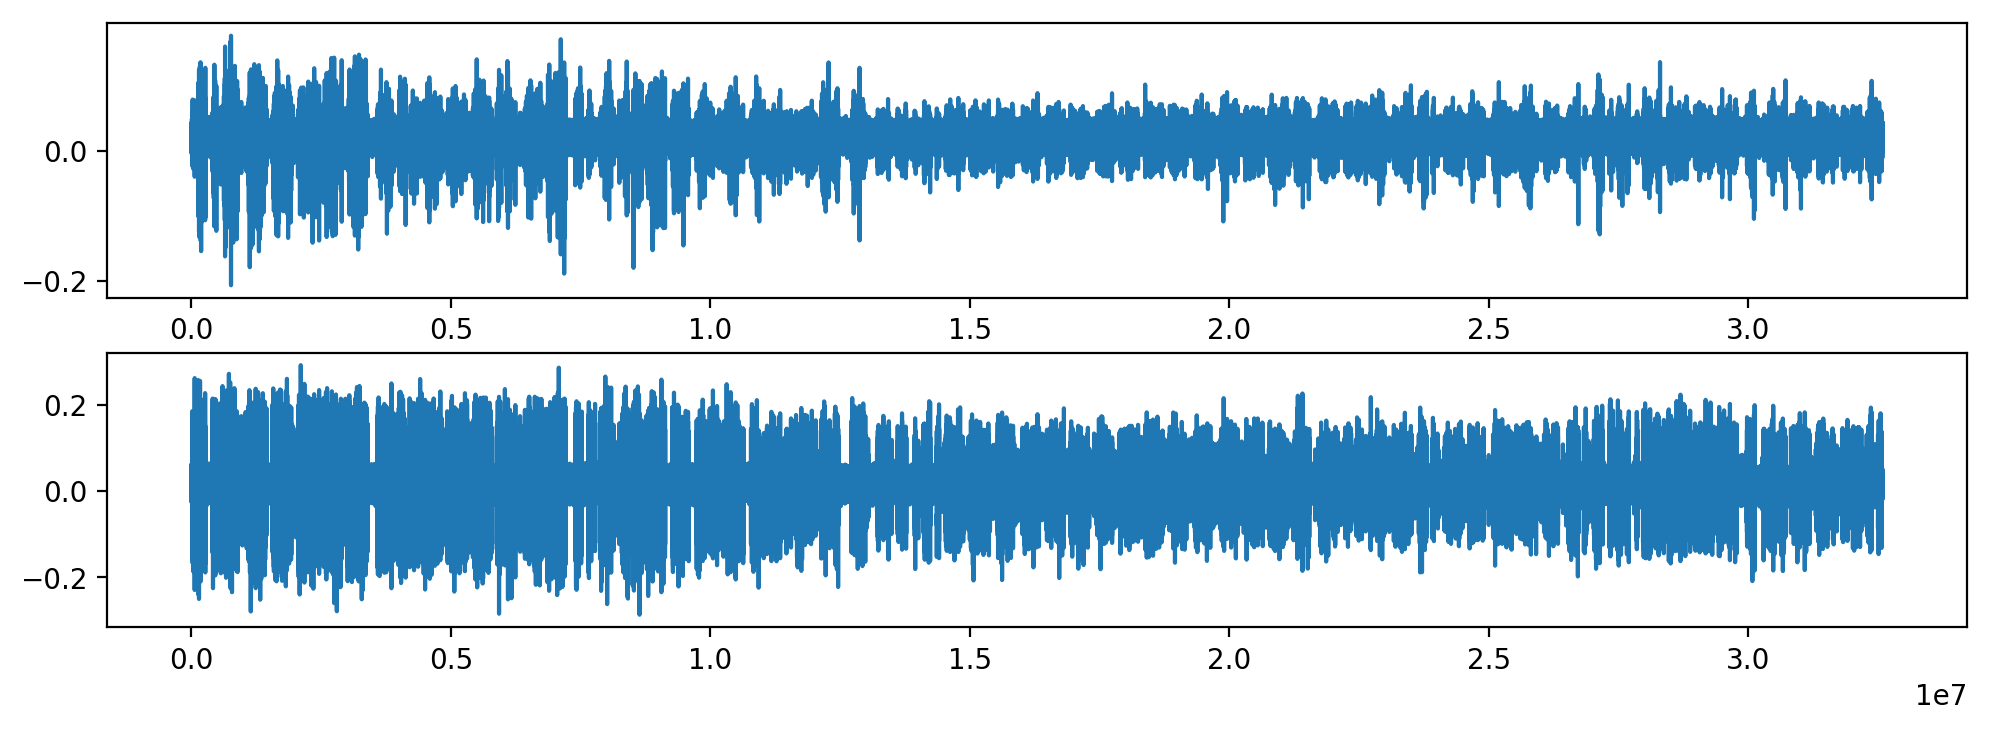

In [5]:
fig, axs = plt.subplots(nrows=2,dpi=200, figsize=(12,4))
axs[0].plot(data[0])
axs[1].plot(data[1])

In [6]:
ch = 1

In [7]:
swims = ep.estimate_swims(ep_filt[ch])
swim_inds = np.where(swims)[0]

In [8]:
def flip_zscore(x):
    from scipy.stats import zscore
    from numpy import concatenate, median
    x -= median(x)
    
    return zscore(concatenate([x, -x]))[:len(x)]

In [9]:
def width_estimate(signal, peak, window=80, threshold=.5):
    from skimage.exposure import rescale_intensity as rescale
    from numpy import where
    hw = window // 2
    dat = signal[slice(peak - hw, peak + hw)]
    dat = rescale(dat, out_range=(0,1))
    #import pdb; pdb.set_trace()
    
    try:
        first = where(dat[:hw] < threshold)[0][-1]
    except:
        first = None
        
    try:
        last = where(dat[hw:] < threshold)[0][0]
    except:
        last = None
    
    if first is None and last is None:
        return window
    
    elif first is None:
        return 2 * last    
    elif last is None:
        return 2 * (hw - first)
    else:
        return last + hw - first

In [10]:
from fish.image.vol import baseline

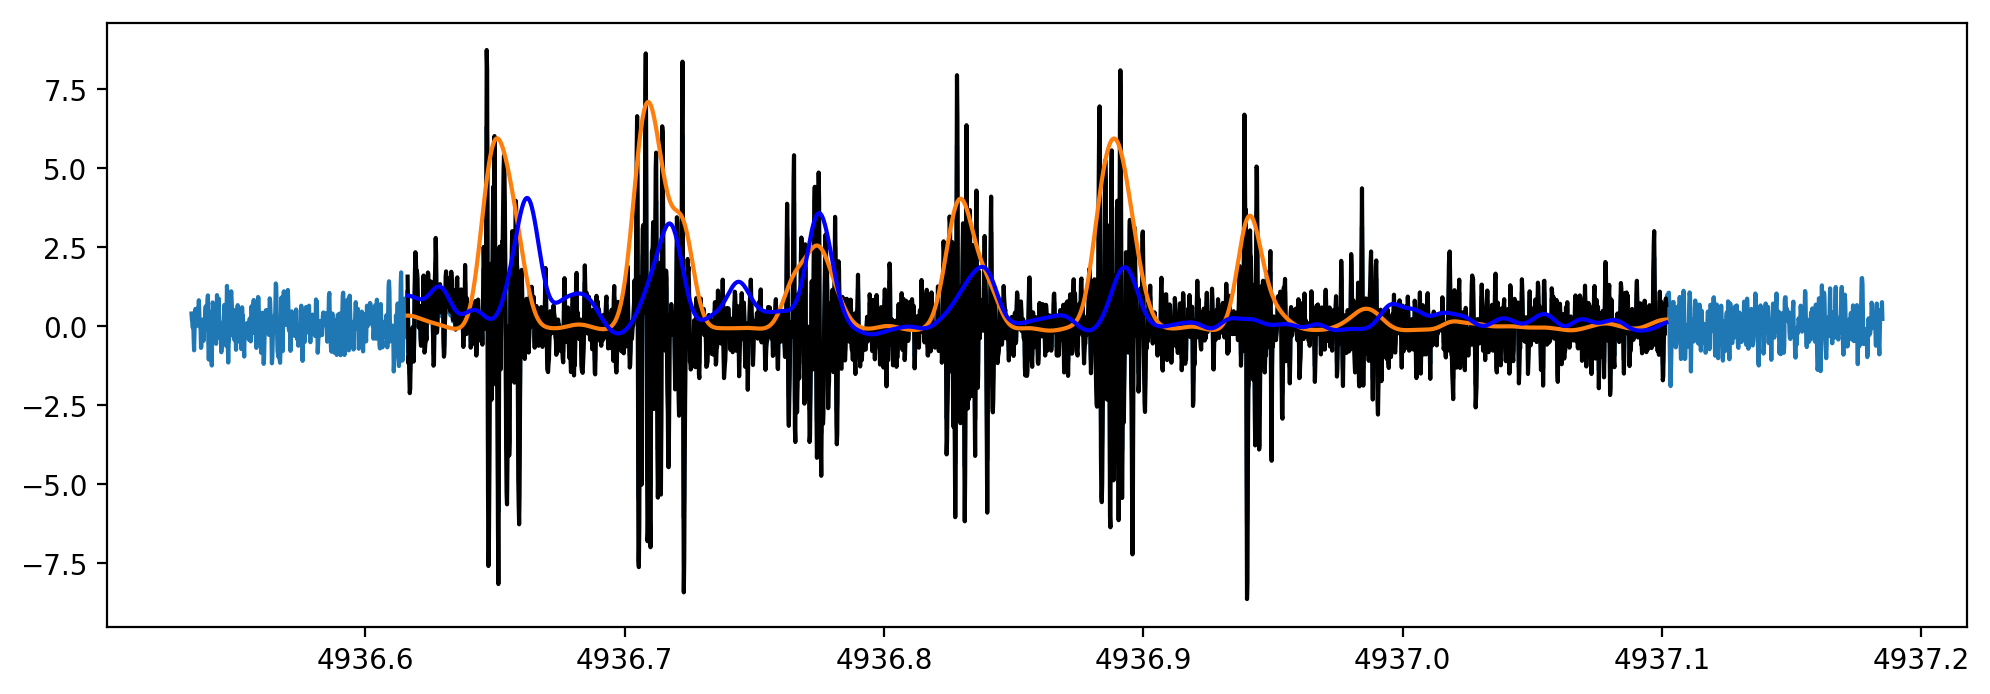

In [20]:
fig, axs = plt.subplots(figsize=(12,4), dpi=200)
inst = swim_df.iloc[np.argsort(swim_df['burst_freqs']).iloc[-5]]
swp = inst['swepochs']
swp_pad = slice(swp.start - 500, swp.stop + 500)
axs.plot(plr[swp_pad] / fs_ep, flip_zscore(data[ch][plr][swp_pad]))
axs.plot(plr[swp] / fs_ep, flip_zscore(data[ch][plr])[swp],'k')
axs.plot(plr[swp] / fs_ep, flip_zscore(ep_filt[ch][plr])[swp])
axs.plot(plr[swp] / fs_ep, flip_zscore(ep_filt[1-ch][plr])[swp], color='b')
#bl = baseline(flip_zscore(data[ch][plr])[swp_pad], window=21, percentile=50)
#axs.plot(plr[swp_pad] / fs_ep, bl)

In [12]:
%matplotlib inline

plr = np.arange(0, data.shape[1], dtype='int')
x_t = np.arange(data.shape[1])[plr] / fs_ep
epf = ep_filt[ch][plr]

swinds = np.where(swims[0][plr])[0] 
bout_durs = (np.where(swims[1][plr])[0] - np.where(swims[0][plr])[0]) 
dur_thr = .1 * fs_ep
keep_trials = bout_durs > dur_thr
swinds = swinds[keep_trials]
bout_durs = bout_durs[keep_trials]

burst_durs = np.zeros(len(swinds), dtype='int')
freqs = np.zeros(len(burst_durs))
swepochs = []
pks = []
pw = 100
for ind, bout in enumerate(swinds):
    swepoch = slice(bout, bout + bout_durs[ind])
    swepochs.append(swepoch)
    swepoch_pad = slice(swepoch.start - pw, swepoch.stop + pw)
    pks_ = pk.indexes(epf[swepoch], thres=.2) + pw
    pks.append(pks_)
    burst_durs[ind] = np.array([width_estimate(epf[swepoch_pad], pk_, window=200) for pk_ in pks_]).mean()
    freqs[ind] = fs_ep/np.mean(np.diff(pks_))
    
nogain = data[-1][swinds] == 0

import pandas as pd
swim_df = pd.DataFrame(data=dict(index=swinds, burst_durs=burst_durs, burst_freqs=freqs, swepochs = swepochs))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

plt.figure(1, figsize=(8, 8), dpi=200)

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
x1 = swim_df.iloc[nogain]['burst_durs'] / fs_ep
y1 = swim_df.iloc[nogain]['burst_freqs']
axScatter.scatter(x1, y1, marker='o', alpha=.4, label=' Gain == 0')

x2 = swim_df.iloc[~nogain]['burst_durs'] / fs_ep
y2 = swim_df.iloc[~nogain]['burst_freqs']
axScatter.scatter(x2, y2, marker='o', alpha=.4, label='Gain > 0')
axScatter.legend()
axScatter.set_xlabel('Burst width (s)')
axScatter.set_ylabel('Burst Frequency (Hz)')
axHistx.hist(x1, 20, histtype='step', linewidth=2)
axHisty.hist(y1, 20,orientation='horizontal', histtype='step', linewidth=2)

axHistx.hist(x2, 20, histtype='step', linewidth=2)
axHisty.hist(y2, 20,orientation='horizontal', histtype='step', linewidth=2)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
axHistx.title.set_text(exp_name)